# Import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, mean_absolute_error

from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBRegressor
import joblib

# MMô hình dự đoán tỷ lệ tử vong ở trẻ sơ sinh

## Dữ liệu từ 1999 - 2022

Xây dựng mô hình dự đoán tỷ lệ tử vong thông qua các yếu tố trong bộ dự liệu từ năm 1999 - 2022.

### Chuẩn bị dữ liệu

In [2]:
data = pd.read_csv("DATA/infant_mortality_data_1999_2022_cleaned.csv")

In [3]:
print("Data size:", data.shape)
data.dtypes

Data size: (22666, 9)


Cause of death             object
Age of mother              object
Mother's education         object
Birth weight               object
Age of infant at death     object
Deaths                      int64
Births                      int64
Death rate per 1000       float64
Year                        int64
dtype: object

In [4]:
data.head()

,Cause of death,Age of mother,Mother's education,Birth weight,Age of infant at death,Deaths,Births,Death rate per 1000,Year
0,Certain infectious and parasitic diseases,15-19,High School Incomplete,500 - 999,672 - 8736,14,1927,7.265179,1999
1,Certain infectious and parasitic diseases,15-19,High School Incomplete,2500 - 2999,672 - 8736,11,31891,0.344925,1999
2,Certain infectious and parasitic diseases,15-19,High School Incomplete,3000 - 3499,672 - 8736,10,31891,0.313568,1999
3,Certain infectious and parasitic diseases,20-24,High School Incomplete,500 - 999,672 - 8736,15,1179,12.722646,1999
4,Certain infectious and parasitic diseases,20-24,High School Graduate,500 - 999,672 - 8736,17,2490,6.827309,1999


In [5]:
features = data.drop(columns=['Death rate per 1000'])
target = data['Death rate per 1000']
features = pd.get_dummies(features, columns=['Cause of death', "Age of mother", "Mother's education", "Birth weight", "Age of infant at death", "Year"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Kmeans

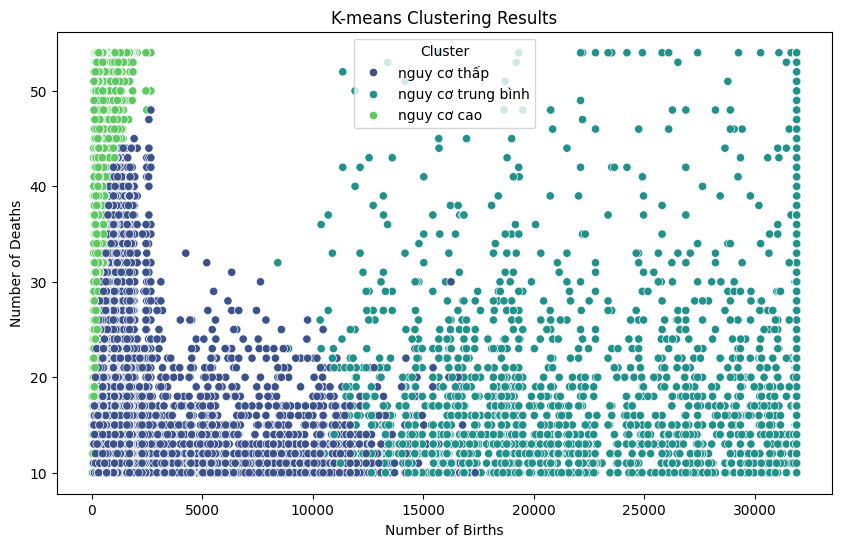

In [7]:
features = data[['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death', 'Deaths', 'Births', 'Death rate per 1000']]

# Chuyển đổi các cột phân loại thành các biến giả (one-hot encoding)
categorical_features = ['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death']
numeric_features = ['Deaths', 'Births', 'Death rate per 1000']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Áp dụng tiền xử lý dữ liệu
scaled_features = preprocessor.fit_transform(features)

# Phân tích phân cụm
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

cluster_labels = {0: "nguy cơ thấp", 1: "nguy cơ cao", 2: "nguy cơ trung bình"}
data['cluster_label'] = data['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Births', y='Deaths', hue='cluster_label', data=data, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Number of Births')
plt.ylabel('Number of Deaths')
plt.legend(title='Cluster')
plt.show()

### Model

In [8]:
# Định nghĩa các mô hình sử dụng
models = {
    "Support Vector Machine": SVR(C=1, epsilon=0.1, kernel='rbf'),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42),
}

In [9]:
# Training các mô hình và lưu trữ các giá trị các metricsrics đánh giá mô hình gồm MSE, RMSE, MAE
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    
    # Tính toán các metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Lưu giá trị metrics vào dictionary
    results[model_name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Predictions": y_pred
    }

### Biểu diễn kết quả

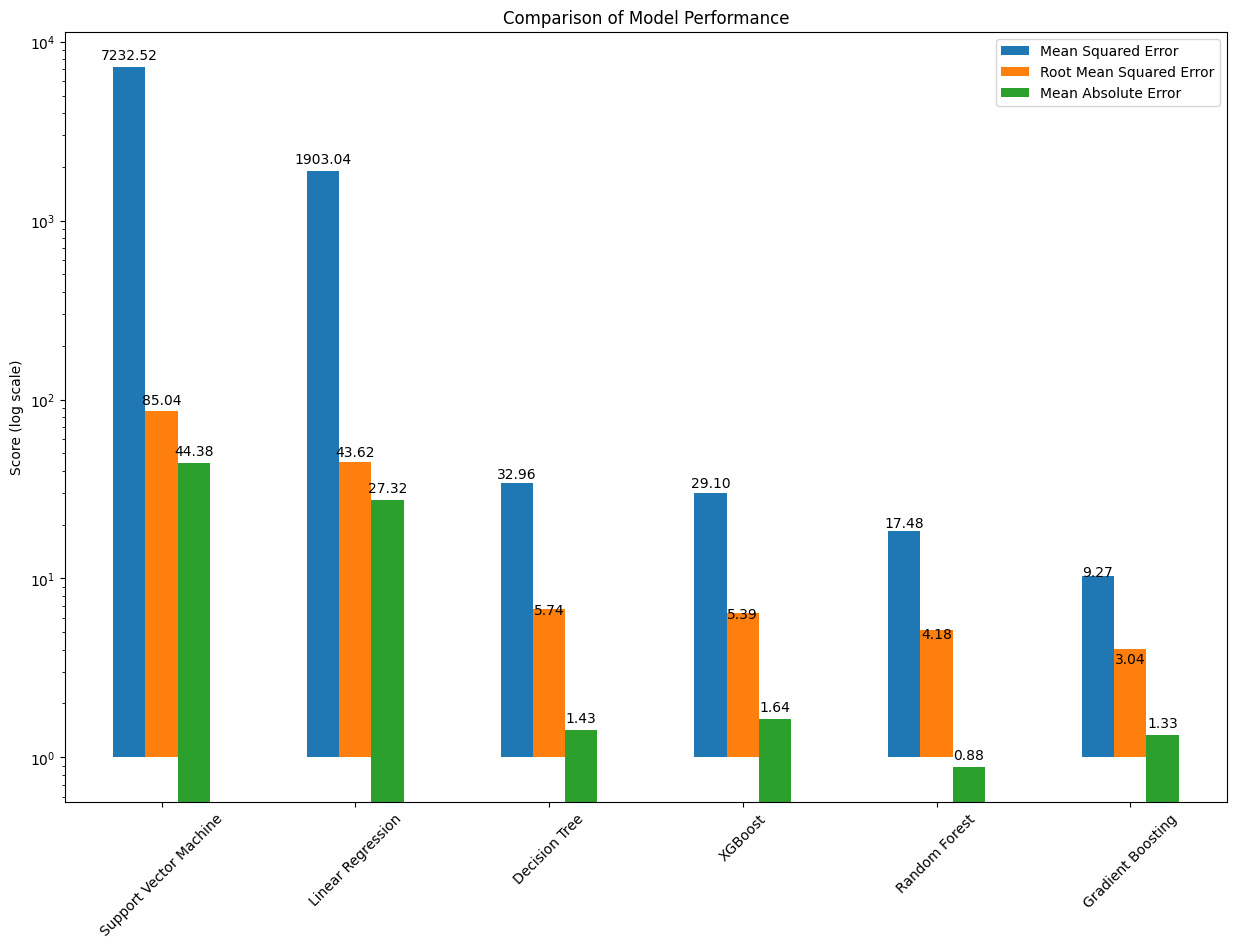

In [10]:
comparison_df = pd.DataFrame(results).T

# Biễu diễn các giá trị metrics dưới dạng biểu đồ nhiều cột, có sủ dụng log để giảm sự sai khác độ cao cột giữa các metrics
ax = comparison_df[['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error']].plot(kind='bar', figsize=(15, 10), log=True)
plt.title('Comparison of Model Performance')
plt.ylabel('Score (log scale)')
plt.xticks(rotation=45)
plt.legend(loc='best')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1), ha='center')

plt.show()

## Dữ liệu 2017 - 2022

Xây dụng mô hình dự đoán tỷ lệ tử vong với dữ liệu từ 2017 - 2022, đặc biệt có thêm các trường dữ liệu như: 

### Chuẩn bị dữ liệu

In [11]:
data = pd.read_csv('DATA/infant_mortality_data_2017_2022_cleaned.csv')

In [12]:
print("Data size:", data.shape)
data.dtypes

Data size: (1443, 9)


Cause of death                 object
NICU Admission                  int64
Antibiotics for Mother          int64
Mother's Pre-pregnancy BMI      int64
Infant birth weight           float64
Deaths                          int64
Births                          int64
Death rate per 1000           float64
Year                            int64
dtype: object

In [13]:
data.head()

,Cause of death,NICU Admission,Antibiotics for Mother,Mother's Pre-pregnancy BMI,Infant birth weight,Deaths,Births,Death rate per 1000,Year
0,Other causes,1,1,2,624.5,12,726,16.56,2017
1,Other causes,1,0,1,624.5,13,1254,10.40,2017
2,Other causes,1,0,1,874.5,10,1701,5.88,2017
3,Other causes,1,0,2,624.5,12,994,12.08,2017
4,Incompetent cervix,0,1,1,249.5,12,270,45.00,2017


In [14]:
features = data.drop(columns=['Death rate per 1000'])
target = data['Death rate per 1000']
features = pd.get_dummies(features, columns=['Cause of death'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Kmeans

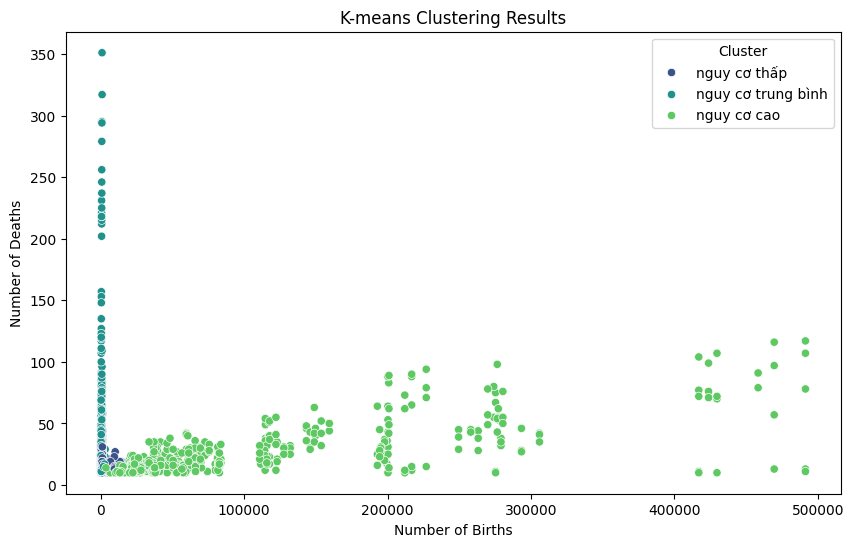

In [16]:
# Chuyển đổi các cột phân loại thành các biến giả (one-hot encoding)
features = data.drop(columns=['Death rate per 1000'])
categorical_features = ['Cause of death']
numeric_features = [ 'NICU Admission', 'Antibiotics for Mother', "Mother's Pre-pregnancy BMI", 'Infant birth weight', 'Deaths', 'Births']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Áp dụng tiền xử lý dữ liệu
scaled_features = preprocessor.fit_transform(features)

# Phân tích phân cụm
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

cluster_labels = {0: "nguy cơ thấp", 1: "nguy cơ cao", 2: "nguy cơ trung bình"}
data['cluster_label'] = data['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Births', y='Deaths', hue='cluster_label', data=data, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Number of Births')
plt.ylabel('Number of Deaths')
plt.legend(title='Cluster')
plt.show()

### Model

In [17]:
# Định nghĩa các mô hình sẽ sử dụng
models = {
    "Support Vector Machine": SVR(C=1, epsilon=0.1, kernel='rbf'),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
}

In [18]:
# Training các mô hình và lưu trữ các giá trị các metricsrics đánh giá mô hình gồm MSE, RMSE, MAE
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    
    # Tính toán các metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
     # Lưu giá trị metrics vào dictionary
    results[model_name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Predictions": y_pred
    }

### Biểu diễn kết quả

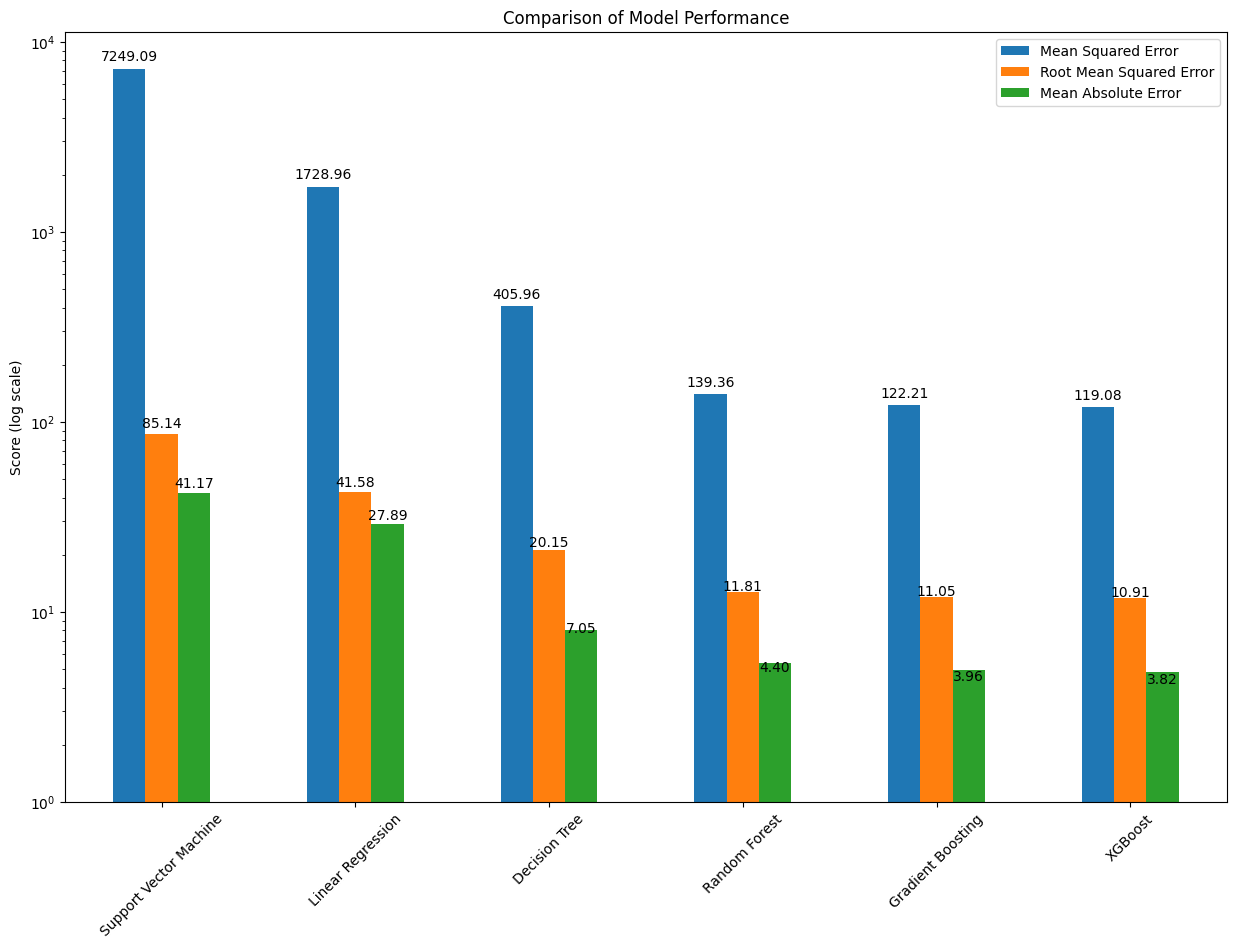

In [19]:
comparison_df = pd.DataFrame(results).T

# Biễu diễn các giá trị metrics dưới dạng biểu đồ nhiều cột, có sủ dụng log để giảm sự sai khác độ cao cột giữa các metrics
ax = comparison_df[['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error']].plot(kind='bar', figsize=(15, 10), log=True)
plt.title('Comparison of Model Performance')
plt.ylabel('Score (log scale)')
plt.xticks(rotation=45)
plt.legend(loc='best')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() * 1.1), ha='center')
plt.show()

# Mô hình dự đoán nguyên nhân tử vong ở trẻ sơ sinh

Mô hình dự đoán nguyên nhân tử vong ở trẻ sơ sinh dựa trên các thông tin từ người dùng:
- `NICU Admission`: (NICU -Neonatal Intensive Care Unit) Chỉ ra liệu trẻ sơ sinh có được chuyển đến khoa chăm sóc đặc biệt cho trẻ hay không. 
- `Antibiotics for Mother`: Chỉ ra liệu người mẹ có sử dụng kháng sinh trong quá trình thai kỳ hay không. 
- `Mother's Pre-pregnancy BMI`: Phản ánh chỉ số khối - thể trạng (BMI) của người mẹ trước khi mang thai. 
- `Infant Birth weight`: Cân nặng khi sinh của trẻ. 
- 

## Trộn dữ liệu

Kết nối 2 dữ liệu từ năm 2017 - 2022 có đủ các cột tăng cường và các cột cơ bản

In [21]:
# Load the datasets
df1 = pd.read_csv('DATA/infant_mortality_data_1999_2022_cleaned.csv')
df2 = pd.read_csv('DATA/infant_mortality_data_2017_2022_cleaned.csv')

# Merge the datasets based on the specified columns
merged_df = pd.merge(df1, df2, on=['Cause of death', 'Year'])

In [22]:
# For columns with _x and _y suffixes, take the average value
for col in merged_df.columns:
    if '_x' in col and col.replace('_x', '_y') in merged_df.columns:
        merged_df[col.replace('_x', '')] = merged_df[[col, col.replace('_x', '_y')]].mean(axis=1)
        merged_df.drop([col, col.replace('_x', '_y')], axis=1, inplace=True)

# Combine 'Infant birth weight' and 'Birth weight' into one column 'Infant birth weight' with the average value
merged_df['Infant birth weight'] = merged_df[['Infant birth weight', 'Birth weight']].mean(axis=1)
merged_df.drop(['Birth weight'], axis=1, inplace=True)

C:\Users\nguye\AppData\Local\Temp\ipykernel_19232\2652878784.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_df['Infant birth weight'] = merged_df[['Infant birth weight', 'Birth weight']].mean(axis=1)


In [37]:
merged_df.shape

(5506, 12)

In [40]:
merged_df.head()

,Cause of death,Age of mother,Mother's education,Age of infant at death,Year,NICU Admission,Antibiotics for Mother,Mother's Pre-pregnancy BMI,Infant birth weight,Deaths,Births,Death rate per 1000
0,Incompetent cervix,20-24,High School Graduate,0 - 1,2017,0,1,1,249.5,14.0,439.0,35.657895
1,Incompetent cervix,20-24,High School Graduate,0 - 1,2017,0,1,3,249.5,14.0,379.5,53.057895
2,Incompetent cervix,20-24,High School Graduate,0 - 1,2017,0,1,4,249.5,13.5,353.0,69.777895
3,Incompetent cervix,20-24,High School Graduate,0 - 1,2017,0,0,1,249.5,36.5,744.0,45.762895
4,Incompetent cervix,20-24,High School Graduate,0 - 1,2017,0,0,2,249.5,39.0,664.5,56.382895


In [41]:
set(merged_df["Mother's education"])

{'College Graduate or Higher',
 'High School Graduate',
 'High School Incomplete',
 'Some College Education'}

In [23]:
# Save the merged dataset to a new CSV file
merged_df.to_csv('DATA/merged_infant_mortality_data.csv', index=False)

## Chuẩn bị dữ liệu

In [24]:
# Load the dataset
data = pd.read_csv('merged_infant_mortality_data.csv')

# Select the relevant columns (excluding 'Year', 'Deaths', 'Births')
columns = ['Cause of death', 'Age of mother', "Mother's education", 'Age of infant at death', 'NICU Admission', 'Antibiotics for Mother', "Mother's Pre-pregnancy BMI", 'Infant birth weight']
data = data[columns]

# Encode categorical variables and save the encoders
label_encoders = {}
for column in ['Cause of death', 'Age of mother', "Mother's education", 'Age of infant at death']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Save the label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Define features and target variable
X = data.drop('Cause of death', axis=1)
y = data['Cause of death']

In [25]:
# Apply Random Over-sampling to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Apply Normalization and Standardization
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [26]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## Định nghĩa mô hình

In [27]:
# Initialize and train the model with reduced complexity
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [28]:
# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores)}")

Cross-Validation Accuracy: 0.7650157232704403


In [29]:
# Make predictions on the test set and get probabilities
y_prob = model.predict_proba(X_test)

# Calculate accuracy and log loss
accuracy = accuracy_score(y_test, model.predict(X_test))
loss = log_loss(y_test, y_prob)

print(f"Accuracy: {accuracy}")
print(f"Log Loss: {loss}")

Accuracy: 0.7562893081761006
Log Loss: 0.5281091749460833


In [30]:
# Save the model and scaler
joblib.dump(model, 'infant_mortality_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Dự đoán nguyên nhân tử vong

In [31]:
def categorize_age(value, categories):
    for category in categories:
        lower_bound, upper_bound = map(int, map(str.strip, category.split('-')))
        if lower_bound <= value <= upper_bound:
            return category
    return None

In [32]:

def predict_cause_of_death(input_data):
    # Load the model and other necessary objects
    model = joblib.load('infant_mortality_model.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoders = joblib.load('label_encoders.pkl')

    # Categorize age values for 'Age of mother' and 'Age of infant at death'
    age_of_mother_categories = label_encoders['Age of mother'].classes_
    age_of_infant_categories = label_encoders['Age of infant at death'].classes_

    input_data[0] = categorize_age(input_data[0], age_of_mother_categories)
    input_data[2] = categorize_age(input_data[2], age_of_infant_categories)

    # Check if categorization was successful
    if input_data[0] is None or input_data[3] is None:
        raise ValueError("Input age values could not be categorized into existing categories.")

    # Encode categorical variables in input data
    input_data[0] = label_encoders['Age of mother'].transform([input_data[0]])[0]
    input_data[1] = label_encoders["Mother's education"].transform([input_data[1]])[0]
    input_data[2] = label_encoders['Age of infant at death'].transform([input_data[2]])[0]

    # Scale the input data
    input_data_scaled = scaler.transform([input_data])

    # Make predictions and get probabilities
    y_prob = model.predict_proba(input_data_scaled)

    # Get the top 5 causes with highest probabilities for the input data
    top_5_indices = np.argsort(y_prob, axis=1)[:, -5:]
    top_5_probabilities = np.take_along_axis(y_prob, top_5_indices, axis=1)

    # Decode the cause of death labels back to original categories
    top_5_causes = np.array([label_encoders['Cause of death'].inverse_transform(indices) for indices in top_5_indices])

    # Combine the results into a dictionary
    num_items = min(5, len(top_5_causes[0]), len(top_5_probabilities[0]))
    result = {top_5_causes[0][j]: top_5_probabilities[0][j] for j in range(num_items)}
    
    # Sort the result by probability in descending order
    result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))

    return result

## Sử dụng mô hình 

In [42]:
def check_input_format(input_data):
    # Check if input_data has the correct length
    if len(input_data) != 7:
        raise ValueError("Input data must have 7 elements.")
    
    # Check if each element has the correct type
    if not isinstance(input_data[0], int):
        raise ValueError("Age of mother must be an integer.")
    if not isinstance(input_data[1], str):
        raise ValueError("Mother's education must be a string.")
    if not isinstance(input_data[2], int):
        raise ValueError("Age of infant at death must be an integer.")
    if not isinstance(input_data[3], int) or input_data[3] not in [0, 1]:
        raise ValueError("NICU Admission must be 0 or 1.")
    if not isinstance(input_data[4], int) or input_data[4] not in [0, 1]:
        raise ValueError("Antibiotics for Mother must be 0 or 1.")
    if not isinstance(input_data[5], float):
        raise ValueError("Mother's Pre-pregnancy BMI must be a float.")
    if not isinstance(input_data[6], float):
        raise ValueError("Infant birth weight must be a float.")

In [45]:
def get_user_input():
    try:
        age_of_mother = int(input("Enter age of mother (integer): "))
        
        # Guide user to select mother's education from specified categories
        education_options = [
            '1. College Graduate or Higher',
            '2. High School Graduate',
            '3. High School Incomplete',
            '4. Some College Education'
        ]
        education_prompt = "\n".join(education_options)
        education_choice = int(input(f"Select mother's education from the following options:\n{education_prompt}\nEnter the number corresponding to mother's education: "))
        if education_choice not in range(1, len(education_options) + 1):
            raise ValueError("Invalid choice for mother's education.")
        mothers_education = education_options[education_choice - 1][3:]  # Extract the education string
        
        age_of_infant_at_death = int(input("Enter age of infant at death (integer): "))
        nicu_admission = int(input("Enter NICU Admission (0 or 1): "))
        antibiotics_for_mother = int(input("Enter Antibiotics for Mother (0 or 1): "))
        mothers_pre_pregnancy_bmi = float(input("Enter mother's pre-pregnancy BMI (float): "))
        infant_birth_weight = float(input("Enter infant birth weight (float): "))
        
        input_data = [
            age_of_mother, mothers_education, age_of_infant_at_death, 
            nicu_admission, antibiotics_for_mother, mothers_pre_pregnancy_bmi, 
            infant_birth_weight
        ]
        return input_data
    except ValueError as e:
        print(f"Invalid input: {e}")
        return None

In [46]:
input_data = get_user_input()
check_input_format(input_data)
if input_data:
    prediction_result = predict_cause_of_death(input_data)
    print("Prediction Result:")
    for cause, prob in prediction_result.items():
        print(f"  {cause}: {prob:.4f}")

Prediction Result:
  Premature rupture: 0.9516
  Chorioamnionitis: 0.0438
  Incompetent cervix: 0.0046
  Accidental suffocation: 0.0000


C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
